## PINNs: Oscillator (PyTorch)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciml-book/sciml_notebook/blob/main/pinns/00-oscillator.ipynb)

## The Damped Harmonic Oscillator in 1D

> This example is adapted from Ben Moseley's [blog post](https://web.archive.org/web/20240618153956/https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/).

The system is described by the following second-order differential equation:

$$
m \frac{d^2 u}{d t^2} + c \frac{d u}{d t} + ku = 0
$$

where:
- $m$ represents the mass of the oscillator
- $c$ is the damping coefficient
- $k$ is the spring constant
- $u$ denotes displacement
- $t$ represents time


The system starts from rest with unit displacement:

$$
u(0) = 1, \quad \frac{d u}{d t}(0) = 0
$$

We focus on the under-damped case, which occurs when:

$$
\delta < \omega_0
$$

The key parameters are:
- Damping ratio: $\delta = \frac{c}{2m}$
- Natural frequency: $\omega_0 = \sqrt{\frac{k}{m}}$

For under-damped motion, the solution takes the form:

$$
x(t) = e^{-\delta t}(2A \cos(\phi + \omega t))
$$

where:
- $\omega = \sqrt{\omega_0^2 - \delta^2}$ is the damped frequency
- $A$ is the amplitude coefficient
- $\phi$ represents the phase angle


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def oscillator(d, w0, x):
    """Analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = np.cos(phi + w * x)
    exp = np.exp(-d * x)
    y = exp * 2 * A * cos
    return y

def create_spring_oscillator_animation_inline():
    d = 2  # damping coefficient
    w0 = 20  # natural frequency
    
    # Animation variables
    totalTime = 1.0  # Time domain [0, 1]
    dt = 0.0075
    t_array = np.arange(0, totalTime, dt)
    y_array = oscillator(d, w0, t_array)

    # Scaling factors
    scale = 1.0
    centerY = 0.0

    # Compute y_min and y_max from the displacement data
    y_min = np.min(y_array * scale + centerY)
    y_max = np.max(y_array * scale + centerY)

    # Create figure and axes
    fig, (ax_trace, ax_spring) = plt.subplots(1, 2, figsize=(12, 4))
    plt.tight_layout(pad=3.0)

    # Plot the displacement curve on ax_trace
    ax_trace.plot(t_array, y_array * scale + centerY, color='gray')
    trace_point, = ax_trace.plot([], [], 'bo', markersize=8)
    ax_trace.set_xlim(0, totalTime)
    ax_trace.set_ylim(-1.1, 1.1)  
    ax_trace.set_xlabel('Time (s)')
    ax_trace.set_ylabel('Displacement')
    ax_trace.set_title('Displacement vs. Time')

    # Set up the mass-spring system on ax_spring
    ax_spring.set_xlim(-1, 1)
    ax_spring.set_ylim(-1.1, 1.1)  
    ax_spring.axis('off')
    ax_spring.set_title('Mass-Spring System')

    # Draw the fixed block at equilibrium position (y=0)
    ax_spring.plot([-0.2, 0.2], [1.0, 1.0], 'k-', linewidth=4)

    # Initialize the mass and spring
    mass, = ax_spring.plot([], [], 'bo', markersize=20)
    spring_line, = ax_spring.plot([], [], 'k-', linewidth=1.5)

    def get_spring(y_start, y_end, coils=10, points_per_coil=15):
        length = y_end - y_start
        t = np.linspace(0, 1, coils * points_per_coil)
        x = 0.06 * np.sin(2 * np.pi * coils * t)
        y = y_start + length * t
        return x, y

    def update(frame):
        t = t_array[frame % len(t_array)]
        y = oscillator(d, w0, t) * scale + centerY

        # Update trace point
        trace_point.set_data([t], [y])

        # Update mass position
        mass.set_data([0], [y])

        # Update spring
        x_spring, y_spring = get_spring(1.0, y)  # Starting from y=1.0 (fixed point)
        spring_line.set_data(x_spring, y_spring)

        return trace_point, mass, spring_line

    ani = FuncAnimation(fig, update, frames=len(t_array), interval=20, blit=True)

    plt.close(fig)
    return HTML(ani.to_jshtml())

# Call the function to display the animation
create_spring_oscillator_animation_inline()

Starting Standard NN Training...


Training Standard NN: 100%|██████████| 25000/25000 [00:06<00:00, 3964.05it/s]



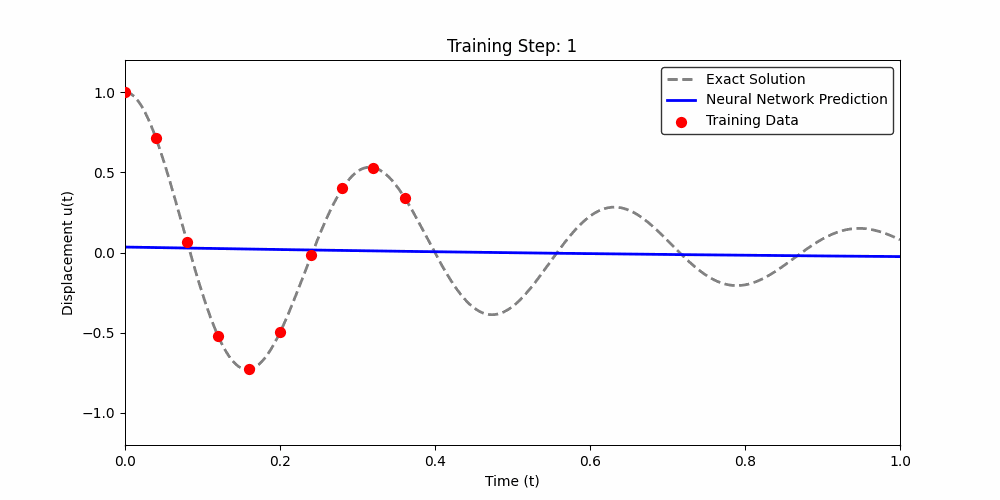

Starting PINN Training...


Training PINN: 100%|██████████| 25000/25000 [00:17<00:00, 1425.89it/s]



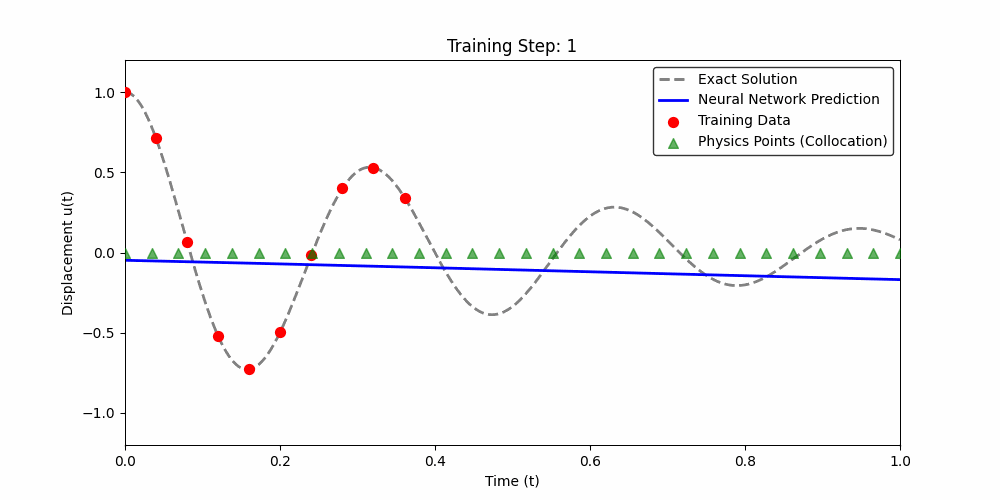


Plotting Phase Portrait...


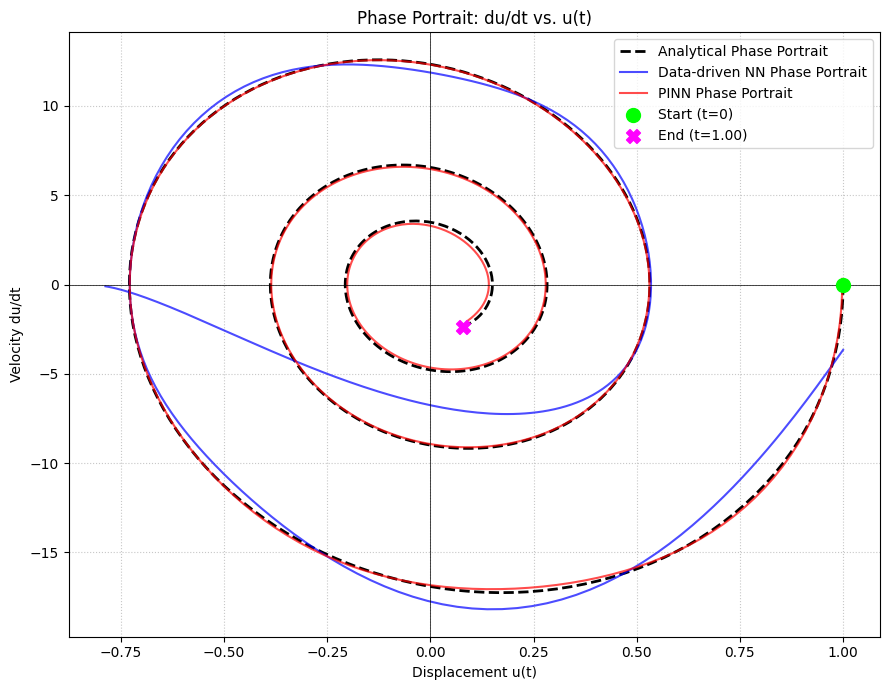


Plotting Derivatives vs. Time...


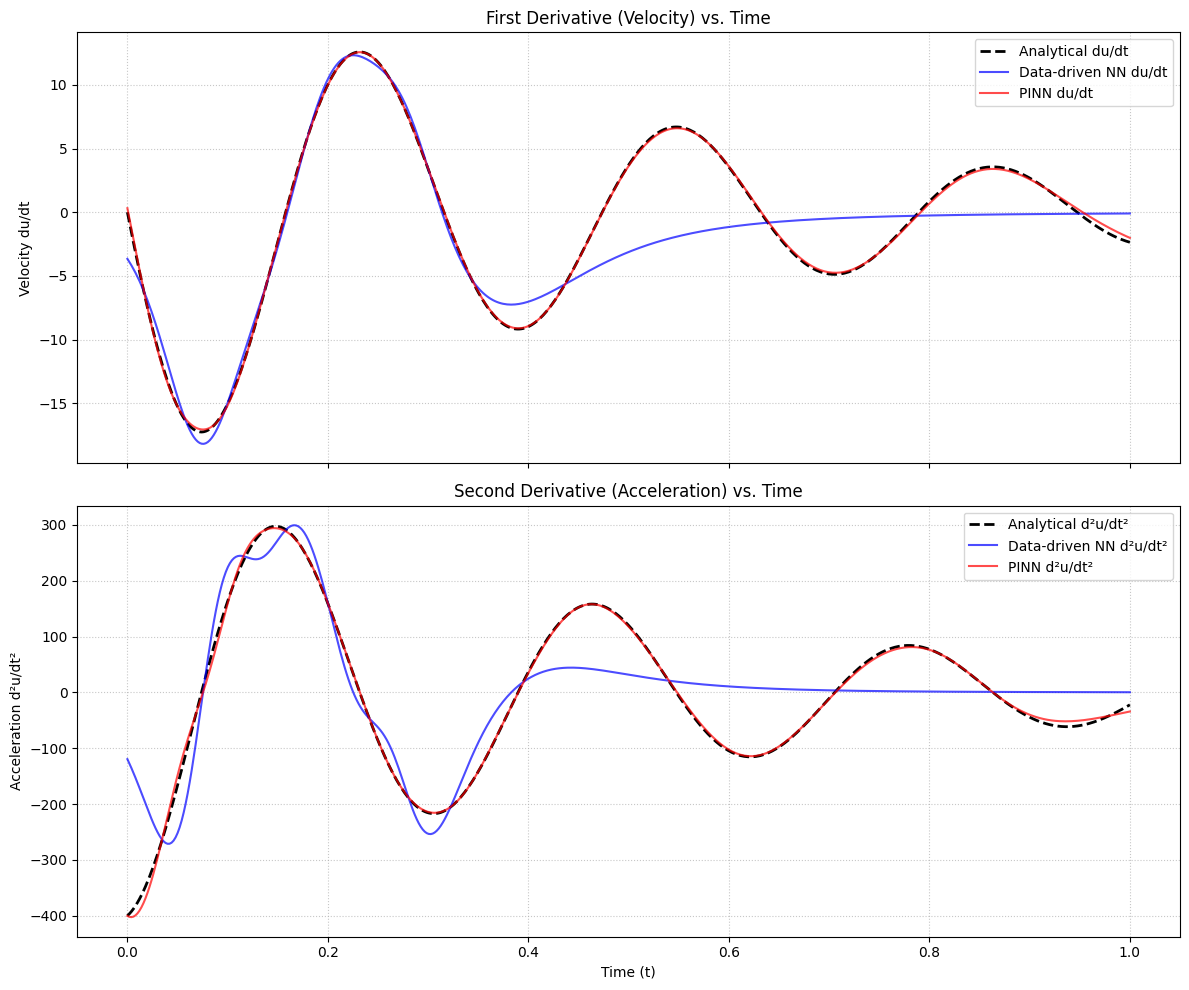


Plotting Displacement vs. Time...


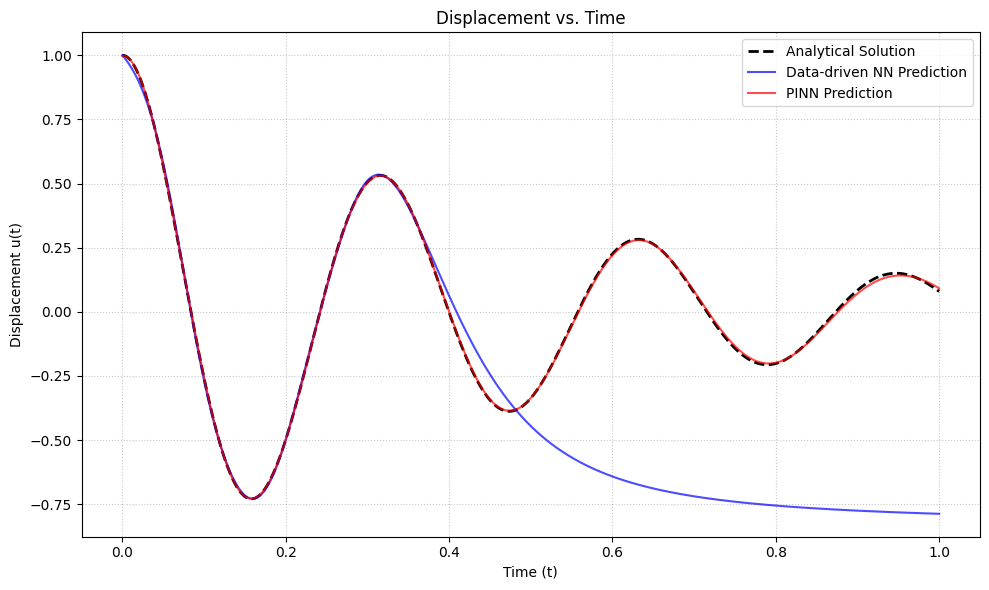


Plotting Loss Histories...


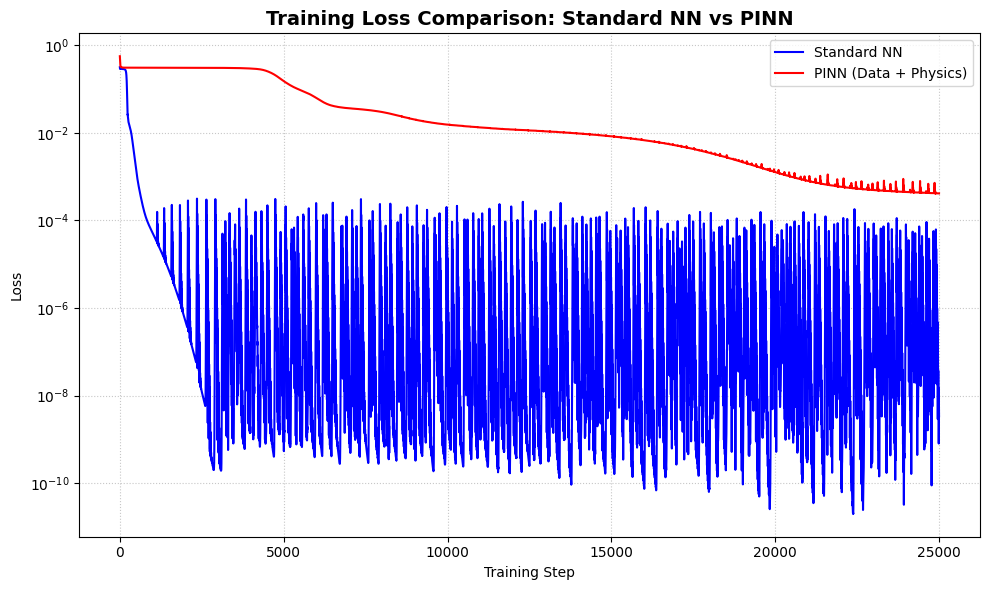

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import base64
from IPython.display import HTML, display
import imageio
from tqdm import tqdm

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

class HarmonicOscillator:
    def __init__(self, damping_coefficient, natural_frequency):
        self.d = damping_coefficient
        self.w0 = natural_frequency
        assert self.d < self.w0, "Damping coefficient must be less than natural frequency for underdamped oscillator"
        self.w = np.sqrt(self.w0**2 - self.d**2) 
        self.phi = np.arctan(-self.d / self.w) 
        self.A = 1 / (2 * np.cos(self.phi))
        
    def analytical_solution(self, t):
        cos_part = np.cos(self.phi + self.w * t)
        exp_part = np.exp(-self.d * t)
        u = exp_part * 2 * self.A * cos_part
        return u

    def analytical_derivative(self, t):
        u_t = self.analytical_solution(t)
        exp_part = np.exp(-self.d * t)
        sin_part = np.sin(self.phi + self.w * t)
        du_dt = -self.d * u_t - exp_part * 2 * self.A * self.w * sin_part
        return du_dt

    def analytical_second_derivative(self, t):
        u_t = self.analytical_solution(t)
        du_dt_val = self.analytical_derivative(t)
        d2u_dt2 = -2 * self.d * du_dt_val - (self.w0**2) * u_t
        return d2u_dt2
    
    def generate_data(self, t_min_overall=0.0, t_max_overall=1.0, num_overall_points=500,
                      data_t_min=0.0, data_t_max=0.3607, num_data_points=10): # Defaults mimic t[0:200:20]
        t_full_domain = np.linspace(t_min_overall, t_max_overall, num_overall_points).reshape(-1, 1)
        u_full_solution = self.analytical_solution(t_full_domain).reshape(-1, 1)

        if data_t_min > data_t_max:
            print(f"Warning in generate_data: data_t_min ({data_t_min}) > data_t_max ({data_t_max}). Swapping them.")
            data_t_min, data_t_max = data_t_max, data_t_min
        
        if data_t_min == data_t_max and num_data_points > 0: # Ensure num_data_points is positive
            t_data = np.full((num_data_points, 1), data_t_min)
        elif num_data_points > 0:
             t_data = np.linspace(data_t_min, data_t_max, num_data_points).reshape(-1, 1)
        else:
            t_data = np.array([]).reshape(-1,1)

        if t_data.size > 0:
            u_data = self.analytical_solution(t_data).reshape(-1, 1)
        else:
            u_data = np.array([]).reshape(-1,1)
            
        return t_full_domain, u_full_solution, t_data, u_data

class Visualizer:
    def __init__(self):
        plt.style.use('default')

    def plot_result(self, t, u_exact, t_data, u_data, u_pred, t_physics=None, iteration=None):
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.grid(False)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.plot(t, u_exact, color="gray", linewidth=2, linestyle='--', label="Exact Solution")
        ax.plot(t, u_pred, color="blue", linewidth=2, label="Neural Network Prediction")
        if t_data.size > 0 :
            ax.scatter(t_data, u_data, color="red", s=50, label="Training Data", zorder=3)

        if t_physics is not None and len(t_physics)>0 :
             ax.scatter(t_physics, np.zeros_like(t_physics), 
                       color="green", s=50, label="Physics Points (Collocation)", marker="^", alpha=0.6, zorder=3)

        if iteration is not None:
            ax.set_title(f"Training Step: {iteration+1}")
        
        ax.legend(frameon=True, facecolor='white', edgecolor='black')
        ax.set_xlabel("Time (t)")
        ax.set_ylabel("Displacement u(t)")
        ax.set_xlim([t.min(), t.max()])
        ax.set_ylim([-1.2, 1.2])
        ax.set_facecolor('white')
        fig.patch.set_facecolor('white')
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        return image

    def create_animation(self, frames, filename='animation.gif'):
        if frames: 
            imageio.mimsave(filename, frames, fps=5, loop=0)
        else:
            print(f"No frames to create animation {filename}")

    def display_animation(self, filename='animation.gif'):
        try:
            with open(filename, 'rb') as f:
                data = f.read()
            data_url = "data:image/gif;base64," + base64.b64encode(data).decode()
            display(HTML(f'<img src="{data_url}">'))
        except FileNotFoundError:
            print(f"Animation file {filename} not found. Make sure training generated frames.")
        except NameError: 
            print(f"Animation saved to {filename}. Display it manually if not in a Jupyter environment.")

class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

def pinn_loss(model, t_data, u_data, t_physics, mu, k):
    # Data loss
    if t_data.numel() > 0 :
        u_pred_data = model(t_data)
        loss_data = nn.MSELoss()(u_pred_data, u_data)
    else:
        loss_data = torch.tensor(0.0, device=mu.device if isinstance(mu, torch.Tensor) else 'cpu')


    # Physics loss
    if t_physics.numel() > 0: 
        t_physics_clone = t_physics.clone().detach().requires_grad_(True)
        u_physics = model(t_physics_clone)

        du_dt = torch.autograd.grad(u_physics, t_physics_clone, grad_outputs=torch.ones_like(u_physics),
                                    create_graph=True)[0]
        d2u_dt2 = torch.autograd.grad(du_dt, t_physics_clone, grad_outputs=torch.ones_like(du_dt),
                                      create_graph=True)[0]
        
        physics_residual = d2u_dt2 + mu * du_dt + k * u_physics
        loss_physics = 1e-4 * torch.mean(physics_residual ** 2) 
    else:
        loss_physics = torch.tensor(0.0, device=mu.device if isinstance(mu, torch.Tensor) else 'cpu') 

    return loss_data + loss_physics

def train_standard_nn(ho, visualizer, 
                      t_min_overall, t_max_overall, num_overall_points,
                      data_t_min, data_t_max, num_data_points):
    print("Starting Standard NN Training...")
    t_domain_np, u_exact_solution_np, t_data_np, u_data_np = ho.generate_data(
        t_min_overall, t_max_overall, num_overall_points,
        data_t_min, data_t_max, num_data_points
    )

    layer_sizes = [1, 32, 32, 32, 1]
    model = NeuralNetwork(layer_sizes)
    
    t_data_tensor = torch.tensor(t_data_np, dtype=torch.float32)
    u_data_tensor = torch.tensor(u_data_np, dtype=torch.float32)
    t_full_domain_tensor = torch.tensor(t_domain_np, dtype=torch.float32)

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    num_steps = 25000
    frames = []
    loss_history_nn = [] # Added to store loss

    for step in tqdm(range(num_steps), desc="Training Standard NN"):
        model.train()
        optimizer.zero_grad()
        u_pred = model(t_data_tensor)
        loss = criterion(u_pred, u_data_tensor)
        loss.backward()
        optimizer.step()
        loss_history_nn.append(loss.item()) # Store loss

        if (step + 1) % 1500 == 0 or step == 0:
            model.eval()
            with torch.no_grad():
                u_pred_full_np = model(t_full_domain_tensor).numpy()
            image = visualizer.plot_result(t_domain_np, u_exact_solution_np, t_data_np, u_data_np, 
                                           u_pred_full_np, t_physics=None, iteration=step)
            frames.append(image)

    visualizer.create_animation(frames, filename='oscillator_nn.gif')
    visualizer.display_animation('oscillator_nn.gif')
    
    model.eval()
    return model, t_full_domain_tensor, loss_history_nn # Return loss history

def train_pinn(ho, visualizer,
               t_min_overall, t_max_overall, num_overall_points,
               data_t_min, data_t_max, num_data_points,
               physics_t_min, physics_t_max, num_physics_points):
    print("Starting PINN Training...")
    t_domain_np, u_exact_solution_np, t_data_np, u_data_np = ho.generate_data(
        t_min_overall, t_max_overall, num_overall_points,
        data_t_min, data_t_max, num_data_points
    )

    mu_phys = 2 * ho.d 
    k_phys = ho.w0**2

    if physics_t_min > physics_t_max:
        print(f"Warning in train_pinn: physics_t_min ({physics_t_min}) > physics_t_max ({physics_t_max}). Swapping them.")
        physics_t_min, physics_t_max = physics_t_max, physics_t_min

    if num_physics_points > 0 and physics_t_min <= physics_t_max :
        t_physics_np = np.linspace(physics_t_min, physics_t_max, num_physics_points).reshape(-1, 1)
    else:
        t_physics_np = np.array([]).reshape(-1,1) 
        print("Warning: No physics points will be used based on input parameters for PINN.")

    layer_sizes = [1, 32, 32, 32, 1]
    model = NeuralNetwork(layer_sizes)

    t_data_tensor = torch.tensor(t_data_np, dtype=torch.float32)
    u_data_tensor = torch.tensor(u_data_np, dtype=torch.float32)
    t_full_domain_tensor = torch.tensor(t_domain_np, dtype=torch.float32)
    t_physics_tensor = torch.tensor(t_physics_np, dtype=torch.float32)
    
    mu_tensor = torch.tensor(mu_phys, dtype=torch.float32)
    k_param_tensor = torch.tensor(k_phys, dtype=torch.float32)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    num_steps = 25000
    frames = []
    loss_history_pinn = [] # Added to store loss

    for step in tqdm(range(num_steps), desc="Training PINN"):
        model.train()
        optimizer.zero_grad()
        loss = pinn_loss(model, t_data_tensor, u_data_tensor, t_physics_tensor, mu_tensor, k_param_tensor)
        loss.backward()
        optimizer.step()
        loss_history_pinn.append(loss.item())

        if (step + 1) % 1500 == 0 or step == 0:
            model.eval()
            with torch.no_grad():
                u_pred_full_np = model(t_full_domain_tensor).numpy()
            image = visualizer.plot_result(t_domain_np, u_exact_solution_np, t_data_np, u_data_np, 
                                           u_pred_full_np, t_physics=t_physics_np if len(t_physics_np)>0 else None, iteration=step)
            frames.append(image)

    visualizer.create_animation(frames, filename='oscillator_pinn.gif')
    visualizer.display_animation('oscillator_pinn.gif')
    
    model.eval()
    return model, t_full_domain_tensor, loss_history_pinn

def plot_phase_portrait(model_nn, model_pinn, oscillator, t_full_domain_tensor, 
                        analytical_u_np, analytical_du_dt_np):
    print("\nPlotting Phase Portrait...")
    model_nn.eval()
    model_pinn.eval()

    t_for_grad = t_full_domain_tensor.clone().detach().requires_grad_(True)
    u_pred_nn = model_nn(t_for_grad)
    du_dt_pred_nn = torch.autograd.grad(u_pred_nn, t_for_grad, grad_outputs=torch.ones_like(u_pred_nn), create_graph=False)[0]
    
    t_for_grad_pinn = t_full_domain_tensor.clone().detach().requires_grad_(True)
    u_pred_pinn = model_pinn(t_for_grad_pinn)
    du_dt_pred_pinn = torch.autograd.grad(u_pred_pinn, t_for_grad_pinn, grad_outputs=torch.ones_like(u_pred_pinn), create_graph=False)[0]

    u_pred_nn_np = u_pred_nn.detach().numpy()
    du_dt_pred_nn_np = du_dt_pred_nn.detach().numpy()
    u_pred_pinn_np = u_pred_pinn.detach().numpy()
    du_dt_pred_pinn_np = du_dt_pred_pinn.detach().numpy()

    plt.figure(figsize=(9, 7))
    plt.plot(analytical_u_np, analytical_du_dt_np, "k--", linewidth=2, label="Analytical Phase Portrait")
    plt.plot(u_pred_nn_np, du_dt_pred_nn_np, "b-", linewidth=1.5, label="Data-driven NN Phase Portrait", alpha=0.7)
    plt.plot(u_pred_pinn_np, du_dt_pred_pinn_np, "r-", linewidth=1.5, label="PINN Phase Portrait", alpha=0.7)
    
    if len(analytical_u_np) > 0:
        plt.scatter(analytical_u_np[0], analytical_du_dt_np[0], marker='o', color='lime', s=100, zorder=5, label="Start (t=0)")
        plt.scatter(analytical_u_np[-1], analytical_du_dt_np[-1], marker='X', color='magenta', s=100, zorder=5, label=f"End (t={t_full_domain_tensor.max().item():.2f})")

    plt.xlabel("Displacement u(t)")
    plt.ylabel("Velocity du/dt")
    plt.title("Phase Portrait: du/dt vs. u(t)")
    plt.legend(loc='best')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_derivatives_vs_time(model_nn, model_pinn, oscillator, t_full_domain_tensor,
                             analytical_du_dt_np, analytical_d2u_dt2_np):
    print("\nPlotting Derivatives vs. Time...")
    model_nn.eval()
    model_pinn.eval()

    t_np = t_full_domain_tensor.detach().numpy().ravel()

    t_for_grad_nn = t_full_domain_tensor.clone().detach().requires_grad_(True)
    u_pred_nn = model_nn(t_for_grad_nn)
    du_dt_pred_nn = torch.autograd.grad(u_pred_nn, t_for_grad_nn, grad_outputs=torch.ones_like(u_pred_nn), create_graph=True)[0]
    d2u_dt2_pred_nn = torch.autograd.grad(du_dt_pred_nn, t_for_grad_nn, grad_outputs=torch.ones_like(du_dt_pred_nn), create_graph=False)[0]

    t_for_grad_pinn = t_full_domain_tensor.clone().detach().requires_grad_(True)
    u_pred_pinn = model_pinn(t_for_grad_pinn)
    du_dt_pred_pinn = torch.autograd.grad(u_pred_pinn, t_for_grad_pinn, grad_outputs=torch.ones_like(u_pred_pinn), create_graph=True)[0]
    d2u_dt2_pred_pinn = torch.autograd.grad(du_dt_pred_pinn, t_for_grad_pinn, grad_outputs=torch.ones_like(du_dt_pred_pinn), create_graph=False)[0]

    du_dt_pred_nn_np = du_dt_pred_nn.detach().numpy().ravel()
    d2u_dt2_pred_nn_np = d2u_dt2_pred_nn.detach().numpy().ravel()
    du_dt_pred_pinn_np = du_dt_pred_pinn.detach().numpy().ravel()
    d2u_dt2_pred_pinn_np = d2u_dt2_pred_pinn.detach().numpy().ravel()
    
    analytical_du_dt_np = analytical_du_dt_np.ravel()
    analytical_d2u_dt2_np = analytical_d2u_dt2_np.ravel()

    fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    axs[0].plot(t_np, analytical_du_dt_np, "k--", linewidth=2, label="Analytical du/dt")
    axs[0].plot(t_np, du_dt_pred_nn_np, "b-", linewidth=1.5, label="Data-driven NN du/dt", alpha=0.7)
    axs[0].plot(t_np, du_dt_pred_pinn_np, "r-", linewidth=1.5, label="PINN du/dt", alpha=0.7)
    axs[0].set_ylabel("Velocity du/dt")
    axs[0].legend(loc='best')
    axs[0].set_title("First Derivative (Velocity) vs. Time")
    axs[0].grid(True, linestyle=':', alpha=0.7)

    axs[1].plot(t_np, analytical_d2u_dt2_np, "k--", linewidth=2, label="Analytical d²u/dt²")
    axs[1].plot(t_np, d2u_dt2_pred_nn_np, "b-", linewidth=1.5, label="Data-driven NN d²u/dt²", alpha=0.7)
    axs[1].plot(t_np, d2u_dt2_pred_pinn_np, "r-", linewidth=1.5, label="PINN d²u/dt²", alpha=0.7)
    axs[1].set_xlabel("Time (t)")
    axs[1].set_ylabel("Acceleration d²u/dt²")
    axs[1].legend(loc='best')
    axs[1].set_title("Second Derivative (Acceleration) vs. Time")
    axs[1].grid(True, linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_displacement_vs_time(model_nn, model_pinn, ho, t_full_domain_tensor):
    print("\nPlotting Displacement vs. Time...")
    model_nn.eval()
    model_pinn.eval()

    # Ensure t_full_domain_tensor is correctly shaped for analytical solution if it expects (N,1)
    t_np_for_analytical = t_full_domain_tensor.detach().numpy() # Keep as (N,1) or (N,) as needed by ho.analytical_solution
    if t_np_for_analytical.ndim == 1:
        t_np_for_analytical = t_np_for_analytical.reshape(-1,1)

    t_np_plot = t_full_domain_tensor.detach().numpy().ravel() # For x-axis of plots

    u_pred_nn = model_nn(t_full_domain_tensor).detach().numpy().ravel()
    u_pred_pinn = model_pinn(t_full_domain_tensor).detach().numpy().ravel()
    
    analytical_u_np = ho.analytical_solution(t_np_for_analytical).ravel()


    plt.figure(figsize=(10, 6))
    plt.plot(t_np_plot, analytical_u_np, "k--", linewidth=2, label="Analytical Solution")
    plt.plot(t_np_plot, u_pred_nn, "b-", linewidth=1.5, label="Data-driven NN Prediction", alpha=0.7)
    plt.plot(t_np_plot, u_pred_pinn, "r-", linewidth=1.5, label="PINN Prediction", alpha=0.7)

    plt.xlabel("Time (t)")
    plt.ylabel("Displacement u(t)")
    plt.title("Displacement vs. Time")
    plt.legend(loc='best')
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_loss_histories(loss_nn, loss_pinn):
    """Plots the training loss histories for Standard NN and PINN on the same plot."""
    print("\nPlotting Loss Histories...")
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Plot both losses on the same axes
    ax.plot(loss_nn, color='blue', label='Standard NN', linewidth=1.5)
    ax.plot(loss_pinn, color='red', label='PINN (Data + Physics)', linewidth=1.5)
    
    # Set logarithmic scale and formatting
    ax.set_yscale('log')
    ax.set_title('Training Loss Comparison: Standard NN vs PINN', fontsize=14, fontweight='bold')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Loss')
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.legend()
    
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # --- Configuration Variables ---
    OVERALL_T_MIN = 0.0
    OVERALL_T_MAX = 1.0
    NUM_OVERALL_POINTS = 500

    DATA_T_MIN = 0.0
    DATA_T_MAX = 0.3607
    NUM_DATA_POINTS = 10

    PHYSICS_T_MIN = 0.0
    PHYSICS_T_MAX = 1.0 # Changed from 0.8 to 1.0 as per user's last code
    NUM_PHYSICS_POINTS = 30

    DAMPING_COEFFICIENT = 2
    NATURAL_FREQUENCY = 20
    # --- End Configuration ---

    ho = HarmonicOscillator(damping_coefficient=DAMPING_COEFFICIENT, natural_frequency=NATURAL_FREQUENCY)
    visualizer = Visualizer()

    t_full_np_for_analytical, _, _, _ = ho.generate_data(
        OVERALL_T_MIN, OVERALL_T_MAX, NUM_OVERALL_POINTS,
        DATA_T_MIN, DATA_T_MAX, NUM_DATA_POINTS
    )
    analytical_u_np = ho.analytical_solution(t_full_np_for_analytical).ravel()
    analytical_du_dt_np = ho.analytical_derivative(t_full_np_for_analytical).ravel()
    analytical_d2u_dt2_np = ho.analytical_second_derivative(t_full_np_for_analytical).ravel()

    # Train standard neural network
    model_nn, t_tensor_nn, loss_history_nn = train_standard_nn(
        ho, visualizer,
        OVERALL_T_MIN, OVERALL_T_MAX, NUM_OVERALL_POINTS,
        DATA_T_MIN, DATA_T_MAX, NUM_DATA_POINTS
    )

    # Train PINN
    model_pinn, t_tensor_pinn, loss_history_pinn = train_pinn(
        ho, visualizer,
        OVERALL_T_MIN, OVERALL_T_MAX, NUM_OVERALL_POINTS,
        DATA_T_MIN, DATA_T_MAX, NUM_DATA_POINTS,
        PHYSICS_T_MIN, PHYSICS_T_MAX, NUM_PHYSICS_POINTS
    )

    plot_phase_portrait(model_nn, model_pinn, ho, t_tensor_nn, 
                        analytical_u_np, analytical_du_dt_np)

    plot_derivatives_vs_time(model_nn, model_pinn, ho, t_tensor_nn,
                             analytical_du_dt_np, analytical_d2u_dt2_np)
    
    plot_displacement_vs_time(model_nn, model_pinn, ho, t_tensor_nn)

    plot_loss_histories(loss_history_nn, loss_history_pinn)